In [60]:
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, parent_dir)

from pyslfp import FingerPrint, plot_SHGrid, ResponseFields
import oldsolver.RFmod as RF
import oldsolver.SLmod as SL
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as crs 
import cartopy.feature as cfeature
import cmocean
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Plotting
def plot_from_shgrid(fun, ax, vmin=None, vmax=None, cmap='cmo.balance_r'):
    ## Function that organises SHGrid objects and plots them correctly
    ## Might be extended to include plot_kwargs and cbar_kwargs

    if vmin is None and vmax is None:
        maxval = np.max(np.abs(fun.data))
        vmin = -maxval
        vmax = maxval

    field = ax.pcolormesh(fun.lons()-180,fun.lats(),fun.data, cmap=cmap, vmin=vmin, vmax=vmax)
    
    axins = inset_axes(ax, width="100%",height="5%",loc='lower left',bbox_to_anchor=(0.00, -0.15, 1, 1),bbox_transform=ax.transAxes,borderpad=0)
    cbar = plt.colorbar(field,cax=axins,orientation='horizontal')
    #cbar.set_label(r'[Mass / Unit area]',labelpad=8)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
# Aim: to compare fingerprint calculations between the old and new codes

# Preliminaries for the old code
L = 64
Q = RF.sobolev_covariance(L, s=2, mu=0.2)
sl0,ice0 = SL.get_sl_ice_data(L)
C = SL.ocean_function(sl0,ice0)
rhow = SL.rhow
b = SL.b
g = SL.g

# Preliminaries for the new code
fingerprint = FingerPrint(64, grid='GLQ')
fingerprint.set_background_state_from_ice_ng(version = 6)


[[<cartopy.mpl.feature_artist.FeatureArtist at 0x7f29b015bad0>,

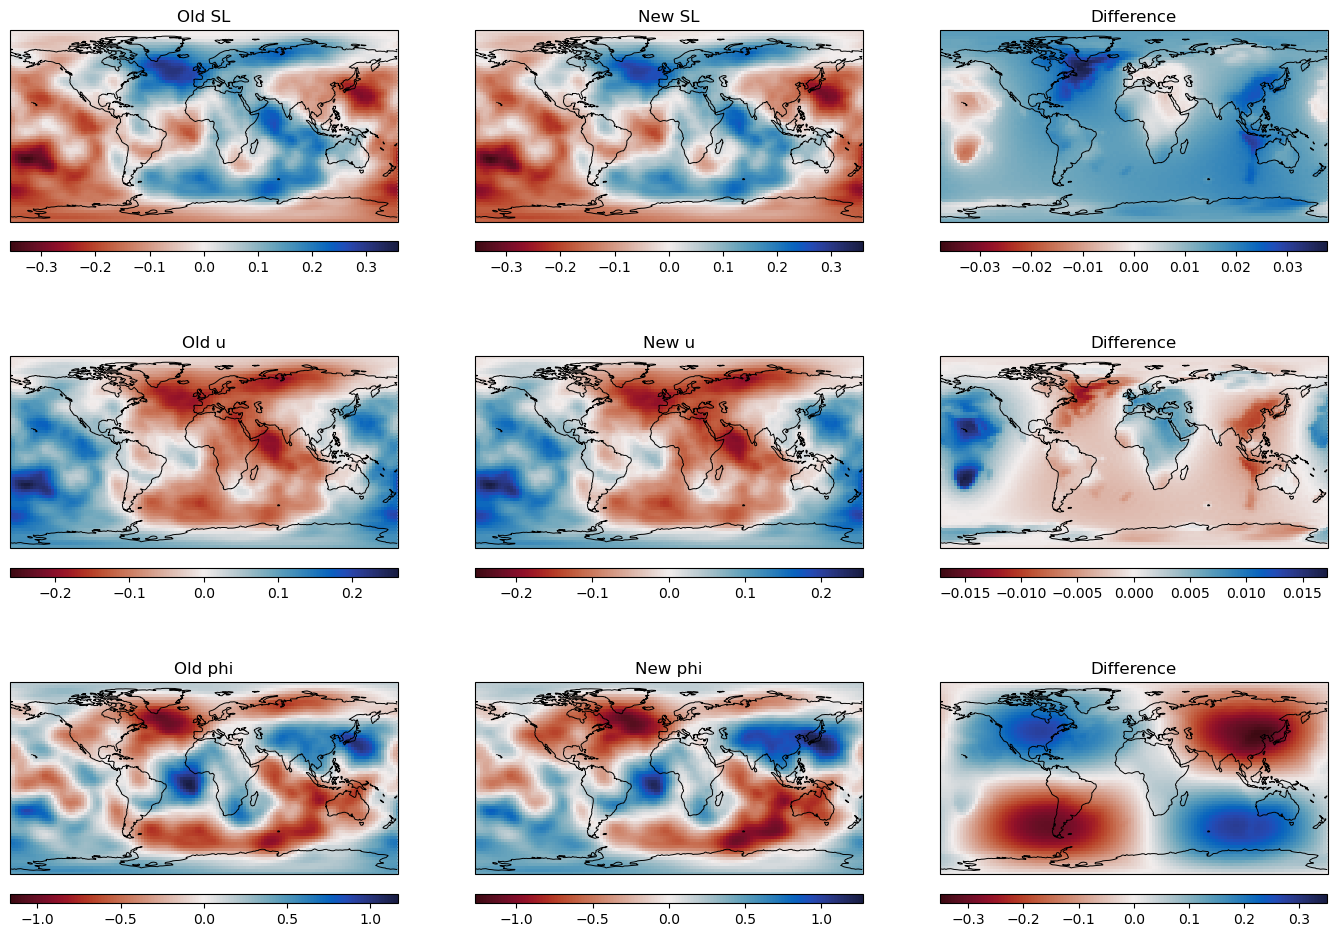

In [77]:
# Create a random load, and calculate the response fields using both codes
zeta = -rhow * RF.random_field(Q)

# Old code
sl, u, phi, om, _ = SL.fingerprint(C, zeta, verbose=False)
old_response = ResponseFields(u, phi, om, sl)

# New code
new_response = fingerprint.solver(zeta)

# Compare the response fields
fig, ax = plt.subplots(3, 3, figsize=(17,12), subplot_kw=dict(projection=crs.PlateCarree()))

# sl
plot_from_shgrid(old_response.sl, ax[0,0])
plot_from_shgrid(new_response.sl, ax[0,1])
plot_from_shgrid(old_response.sl - new_response.sl, ax[0,2])
[a.set_title(t) for a,t in zip(ax[0,:], ['Old SL', 'New SL', 'Difference'])]

# u
plot_from_shgrid(old_response.u, ax[1,0])
plot_from_shgrid(new_response.u, ax[1,1])
plot_from_shgrid(old_response.u - new_response.u, ax[1,2])
[a.set_title(t) for a,t in zip(ax[1,:], ['Old u', 'New u', 'Difference'])]

# phi
plot_from_shgrid(old_response.phi, ax[2,0])
plot_from_shgrid(new_response.phi, ax[2,1])
plot_from_shgrid(old_response.phi - new_response.phi, ax[2,2])
[a.set_title(t) for a,t in zip(ax[2,:], ['Old phi', 'New phi', 'Difference'])]

[[a.add_feature(cfeature.COASTLINE, zorder=1, linewidth=0.7) for a in ax[i,:]] for i in range(3)]
